<h1 align="center"><font color="0066FF" size=110>Partial Differential Equations II: 2D Laplace Equation on 5x5 grid</font></h1>


In [1]:
import numpy as np
import scipy as sp
import scipy.linalg
import matplotlib
from IPython.html.widgets import interact
from IPython.display import Image
try:
    %matplotlib inline
except:
    # not in notebook
    pass
LECTURE = True
if LECTURE:
    size = 20
    matplotlib.rcParams['figure.figsize'] = (9, 4)
    matplotlib.rcParams['axes.labelsize'] = size
    matplotlib.rcParams['axes.titlesize'] = size
    matplotlib.rcParams['xtick.labelsize'] = size * 0.6
    matplotlib.rcParams['ytick.labelsize'] = size * 0.6
import matplotlib.pyplot as plt



:0: FutureWarning: IPython widgets are experimental and may change in the future.


# Learning Outcomes

After studying this notebook you should be able to
-   Generate structured grids in 1D and 2D, using for example NumPy's `linspace` and `meshgrid` functions in Python.
-   Plot a 2D array using Matplotlib with `imshow` or `pcolor`
-   Discretise the 2D Laplace equation over a uniform structured grid using the first central finite difference approximation for the second derivative.
-   Write a computer program to solve the Laplace equation in 2D using the finite difference method on a 5x5 grid

# Introduction

This notebook generalised the 1D Laplace solver of our first PDE lecture to 2D. We will start by discretising the 2D Laplace equation by using the first central finite difference approximation for the second derivatives. This will yield a linear system of equations which we will derive explicitely for a 5x5 grid, before generalising for an NxN grid. Finally, we will implement and solve this system of equation using Python.

# Laplace equation in 2D

The 2D Laplace equation takes the form

\begin{equation}
\frac{\partial^2 T(x,y)}{\partial x^2}  + \frac{\partial^2 T(x,y)}{\partial y^2} = 0, \quad \text{with boundary conditions for} \quad T(x,y).
\end{equation}

The Laplace equation can be seen as the steady state form of the Heat equation. It describes how the temperature $T$ varies accross a bounded domain in equilibrium, with fixed boundary conditions.

Let's solve the above equation for $0 \leq x \leq L$ and $0 \leq y\leq L$, with boundary conditions

\begin{align}
T(x, 0) &= T_e, &
T(x, L) &= 0, &
T(0, y) &= 0, &
T(L, y) &= 0.
\end{align}

This means that the bottom edge temperature $y=0$ is held at temperature $T_e$,  and that the other boundaries are held at 0 K.

# Discretisation

The function $T(x,y)$ varies over a bounded but continuous domain $0 \leq x \leq L$, $0 \leq y \leq L$. A complete description of this problem requires an infinite number of points in each directions. This cannot be achieved using a computer with a finite memory, but we can obtain an accurate approximation by using a finite number of points. These points form a mesh, and the accuracy of the approximation depends on the quality of the mesh and on the method used to represent the equation over this mesh. Here, we will use the finite difference method, which was introduced in the previous lecture and used to solve the 1D Laplace equation.

## Meshing: structured vs unstructured

With regards to the mesh, there is a difference between a 1D problem and a 2D problem. First of all, the difference between a mesh and a set of points is that in a mesh, each point is connected to its neighbours. In 1D, this *connectivity* is natural: each point is connected to the previous and next point along a line (or curve). In 2D there are more possibilities, and a larger variety of meshes are possible.

2D meshes can be *structured*, or *unstructured*. Structured meshes can be mapped to a 2D grid and are the natural generalisation of the 1D grids studied in the previous lecture:


![img](fig05-01.png "Structured grids in 1D and 2D. Structured meshes can be mapped to a the type of grids illustrated in this figure. The red dots show the connectivity of each point. *Regular* or *structured* in dimension $N$ have a natural connectivity and can be implemented easily and very efficiently using $N$-dimensional arrays.")

In a 2D grid, each (non-boundary) point is connected to 4 other points located along the cardinal directions: North, West, South, and East. We can see that this will be helpful to compute derivatives along each direction using the finite difference method.

One limitation of structured meshes is that they are not very flexible, as every change in the distribution of the grid along one direction will be automatically replicated in the orthogonal direction. Local changes have global consequences: it is impossible to increase the mesh density locally. For example, the 2D structured mesh of the aerofoil below has an unecessary high mesh density above and below the trailing edge:


![img](fig05-02.png "Example of a non-rectangular structured mesh around a 2D aerofoil. The mesh is composed of 3 blocks (the C-shaped block on the left and the two rectangular blocks on the right). Note that the C-block is indeed structured because the C can be unfolded into a rectangular shape. Splitting the mesh into suitable blocks to generate a structred mesh is challenging for complex geometries. In addition, structured meshes do not allow for *local* changes in the mesh density. Increasing the mesh density near the trailing edge has *global* consequences: the density also increases above the trailing edge, although there is no physical need to have such a high grid resolution.")

On the other hand, unstructured meshes are generally irregular so the number of nodes a point is connected to may vary throughout the mesh. This makes these types of meshes very useful to deal with **complex geometries**: the mesh density can be increased locally wherever necessary (e.g. near corners or sharp edges, or in the boundary layers for CFD applications), and decreased where the geometry is smoother.

For example, this unstructured triangular mesh of a DTU96 wind turbine aerofoil in 2D does not need the unecessary large density of points above and below the trailing edge:


![img](fig05-03.png "Unstructured grids are made of non-rectangular cells such as triangles and are more flexible than regular grids: the density can change locally. This makes them very attractive for modelling complex geometries. However they require more complicated data structures (See Appendix B)")

Unstructured mesh are not well suited to the finite difference method, which is therefore difficult to use for complex geometries. They are commonly used with alternative methods such as the Finite Volume method, or the Finite Element Method.

## Generating 1D and 2D grids with `linspace` and `meshgrid`

The first step in solving our equation numerically is to describe our continuous 2D domain using a finite number of points. This is called discretizing the domain. by using a 2D cartesian grid with uniform spacing.  This type of grid is called a *structured* grid because it has a very regular structure. Structured grids are defined using two one dimensional grids, $(x_j)_{1\leq j\leq N_x}$ and $(y_i)_{1 \leq j \leq N_y}$, that discretize the domain along the $x$ and $y$ directions respectively, as

\begin{align}
X_{i,j} &\equiv x_j, &
Y_{i,j} &\equiv y_i.
\end{align}

In Python, such grids are easily generated using NumPy's `linspace` and `meshgrid` functions. The `linspace` function uniformly spaced grids in 1D, given the min and max values $x_{min}$ and $x_{max}$ of the grid and the number of points $N$:

\begin{equation}
x_i = x_{min} + i \frac{x_{max} - x_{min}}{N-1},
\end{equation}

where $0 \leq i \leq N-1$.

The `meshgrid` function combines two 1D arrays $(x_i)$ and $(y_i)$ and returns the two 2D arrays $X_{i,j}$ and $Y_{i,j}$ defined previously. For example, for a grid with $N_x=N_y=11$ elements in each direction



In [2]:
Nx = Ny = 11
x = np.linspace(0, 1, Nx)
y = np.linspace(0, 1, Ny)
X, Y = np.meshgrid(x, y)
print 'x = y = \n', x
print 'X = \n', X
print 'Y = \n', Y



x = y = 
[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1. ]
X = 
[[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1. ]
 [ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1. ]
 [ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1. ]
 [ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1. ]
 [ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1. ]
 [ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1. ]
 [ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1. ]
 [ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1. ]
 [ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1. ]
 [ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1. ]
 [ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1. ]]
Y = 
[[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]
 [ 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2]
 [ 0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3]
 [ 0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  

Note that the $x$ coordinate increases *horizontally* with the columns of $X$, while the $y$ coordinate increases *vertically* with the rows of $Y$.

## Plotting 2D arrays with `imshow`

This can also be visualised by plotting our 2D arrays `X` and `Y` with matplotlib's `imshow` function:



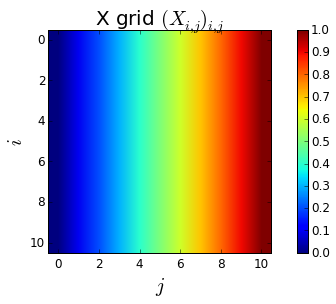

In [3]:
# plot X
plt.figure(4)
plt.clf()
plt.imshow(X)
plt.title('X grid $(X_{i,j})_{i,j}$')
plt.xlabel(r'$j$')
plt.ylabel(r'$i$')
plt.colorbar()
plt.savefig('fig05-04.pdf')



<fig05-04.pdf>

As expected `X` increases with $j$, from 0 to 1 (from left to right).



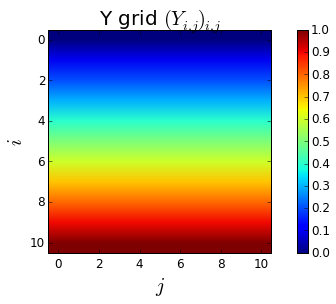

In [4]:
# plot Y
plt.figure(5)
plt.clf()
plt.imshow(Y)
plt.title('Y grid $(Y_{i,j})_{i,j}$')
plt.xlabel(r'$j$')
plt.ylabel(r'$i$')
plt.colorbar()
plt.savefig('fig05-05.pdf')



<fig05-05.pdf>

`Y` varies increases with $i$ (from top to bottom).

Alternatively, we could have used the function `pcolormesh` (see Appendix A), which follows the usual 2D cartesian coordinates conventions ($x$ increasing from left to right, and $y$ increasing from bottom to top).

## Discrete Laplace equation

The first central difference for the second derivative is given by

\begin{align}
f''(x) = \frac{f(x-h) - 2 f(x) + f(x + h)}{h^2} + O(h^2),
\end{align}

which yields

\begin{equation}
\frac{T(x - h_x,y) - 2 T(x,y) + T(x + h_x, y)}{h_x^2}  + \frac{T(x,y - h_y) - 2 T(x,y) + T(x, y + h_y)}{h_y^2} = 0,
\end{equation}

where $h_x$ and $h_y$ are the mesh size in the $x$ and $y$ directions respectively. Assuming a uniform grid $h = h_x = h_y$, we have

\begin{equation}
T(x - h,y) - 2 T(x,y) + T(x + h, y)  + T(x,y - h) - 2 T(x,y) + T(x, y + h) = 0.
\end{equation}

We can view this as a stencil averaging $T(x,y)$ over nearby points, separated by a distance $h$.

The above equation allows us to discretize the continuous Laplace equation in the bounded $0 \leq x \leq L$, $0 \leq y \leq L$ into a discrete equation:

\begin{equation}
T_{i-1, j} + T_{i, j-1} - 4 T_{i,j} + T_{i, j+1} + T_{i+1, j} = 0,
\end{equation}

where

\begin{equation}
T_{i,j} \equiv T(x + ih, y + jh).
\end{equation}

This 5 point stencil operation is illustrated below on a 2D grid:


![img](fig05-06.png "5-point Laplace stencil nodes and coefficients (in red) super-imposed on a 2D array $(T_{ij})$.")

## Linear system of equations on a 5x5 grid

We are now in a position to derive the system of equations for the 2D Laplace equation on a 5x5 grid, over which the temperature is discretized as $(T_{i,j})_{\substack{0 \leq i \lt 3 \\ 0 \leq j \lt 3}}$. Since the boundary conditions are known, only inner points are unknown so we have 3x3=9 unknown mesh points. To simplify the notations let's call $(U_i)_{0 \leq i\lt 9}$ the temperatures at these unknown mesh points, using C ordering (rowise, as opposed to columnwise Fortran ordering), as illustrated below.


![img](fig05-07.png "2D grid layout with row-ordering of the unknowns $(T_{i,j})$ giving 9 unknowns $(U_k)$ at the inner nodes. The boundary temperature is set to 0 except at $y=0$ where $T = T_e = 100K$.")

Going from $(T_{i,j})_{\substack{0 \leq i \lt 3 \\ 0 \leq j \lt 3}}$ to $(U_k)_{0 \leq k\lt 9}$ flattens a 2D array into a 1D array. The advantage of having all of our unknowns in a 1D column vector, is that we can then express our system of equations using the usual form $A U = B$ (where $A$ is a matrix and $B$ a column vector), which is the one expected by linear solvers such as those presented in [notebook 1](http://www.southampton.ac.uk/~feeg6002/lecturenotes/feeg6002_numerical_methods01.html).

Note that we have ordered the $U_k$ unknowns by filling the array one row after the other. This is called a *row-major* format and it is how 2D arrays are stored in memory in C, C++ and Python (NumPy). An alternative is to fill the array one column after other. This is called a *column-major* format and is how 2D arrays are stored in memory in Fortran and MATLAB.

Mathematically, using row-major ordering, $(T_{i,j})_{\substack{0 \leq i \lt 3 \\ 0 \leq j \lt 3}}$ can be expressed in terms of $(U_k)_{0\leq k \lt 9}$ as

\begin{align}
T_{i,j} &= U_k, \quad \text{where} \quad k = i \times N + j.
\end{align}

where $N = 3$ is the column size. Thus, if we can solve our equation for $(U_i)_{0\leq i \lt 9}$, we can easily construct the 2D temperature array $(T_{i,j})_{\substack{0 \leq i \lt 3 \\ 0 \leq j \lt 3}}$ using the above equation.

In Python, flattening a 2D array into a 1D array, or reshaping a 1D array into a 2D array is easily done using NumPy's `flatten` and `reshape` methods:



In [5]:
# Create a 3x3 array
T = np.arange(9).reshape(3,3)
# Flatten the array
U = T.flatten()
# Reshape the array and check that we get back T
Tnew = U.reshape(3,3)
assert np.all(Tnew == T)
# Print T, U and Tnew
print "T = \n", T
print "U = T.flatten() = \n", U
print "T = U.reshape(3,3) = \n", Tnew



T = 
[[0 1 2]
 [3 4 5]
 [6 7 8]]
U = T.flatten() = 
[0 1 2 3 4 5 6 7 8]
T = U.reshape(3,3) = 
[[0 1 2]
 [3 4 5]
 [6 7 8]]


Applying the 5-point Laplacian finite difference stencil described in the previous section at each unknown mesh point, and using the boundary conditions, we get 9 equations:
-   First row:

\begin{equation}
\left\{%
\begin{aligned}
-4 U_0 + U_1 + U_3 &= -T_e \\
U_0 -4U_1 + U_2 + U_4 &= -T_e \\
U_1 -4U_2 + U_5 &= -T_e
\end{aligned}\right.
\end{equation}

-   Second row:

\begin{equation}
\left\{%
\begin{aligned}
U_0 -4 U_3 + U_4 + U_6 &= 0 \\
U_1 + U_3 - 4U_4 + U_5 + U_7 &= 0 \\
U_2 + U_4 - 4U_5 + U_8 &= 0
\end{aligned}\right.
\end{equation}

-   Third row:

\begin{equation}
\left\{%
\begin{aligned}
U_3 -4 U_6 + U_7 &= 0 \\
U_4 + U_6 - 4U_7 + U_8 &= 0 \\
U_5 + U_7 - 4U_8 &= 0
\end{aligned}\right.
\end{equation}

We can write this as a matrix:

\begin{equation}
A u = \left(
\begin{array}{@{}ccc|ccc|ccc@{}}
-4  &  1 &  0 &  1 &  0 &  0 &  0 &  0 &  0  \\
 1  & -4 &  1 &  0 &  1 &  0 &  0 &  0 &  0  \\
 0  &  1 & -4 &  0 &  0 &  1 &  0 &  0 &  0  \\
\hline
 1  &  0 &  0 & -4 &  1 &  0 &  1 &  0 &  0  \\
 0  &  1 &  0 &  1 & -4 &  1 &  0 &  1 &  0  \\
 0  &  0 &  1 &  0 &  1 & -4 &  0 &  0 &  1  \\
\hline
 0  &  0 &  0 &  1 &  0 &  0 & -4 &  1 &  0  \\
 0  &  0 &  0 &  0 &  1 &  0 &  1 & -4 &  1  \\
 0  &  0 &  0 &  0 &  0 &  1 &  0 &  1 & -4
\end{array}\right)
\begin{pmatrix}
U_1 \\ U_2 \\ U_3 \\ U_4 \\ U_5 \\ U_6 \\ U_7 \\ U_8 \\ U_9
\end{pmatrix}
=
\begin{pmatrix}
-T_e \\ -T_e \\ -T_e \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0
\end{pmatrix} = b.\\
\end{equation}

Note that matrix $A$ can be written in block matrix form as:

\begin{align}
A &=
\begin{pmatrix}
B & I & 0 \\
I & B & I \\
0 & I & B
\end{pmatrix}, \quad \text{where} &
I &=
\begin{pmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1
\end{pmatrix}, &
B &=
\begin{pmatrix}
-4 &  1 &  0 \\
 1 & -4 &  1 \\
 0 &  1 & -4
\end{pmatrix}.
\end{align}

One simple way to construct our Laplacian matrix with Python is to use the function `scipy.linalg.block_diag` to construct a diagonal block matrix using block $B$ and to add an upper diagonal of ones, and a lower diagonal of ones, offset by N=3.



In [6]:
B = np.array([[-4,  1,  0], [ 1, -4,  1], [ 0,  1, -4]])
A = sp.linalg.block_diag(B, B, B)
# Upper diagonal array offset by 3
Dupper = np.diag(np.ones(3 * 2), 3)
# Lower diagonal array offset by -3
Dlower = np.diag(np.ones(3 * 2), -3)
A += Dupper + Dlower
print "A = \n", A



A = 
[[-4  1  0  1  0  0  0  0  0]
 [ 1 -4  1  0  1  0  0  0  0]
 [ 0  1 -4  0  0  1  0  0  0]
 [ 1  0  0 -4  1  0  1  0  0]
 [ 0  1  0  1 -4  1  0  1  0]
 [ 0  0  1  0  1 -4  0  0  1]
 [ 0  0  0  1  0  0 -4  1  0]
 [ 0  0  0  0  1  0  1 -4  1]
 [ 0  0  0  0  0  1  0  1 -4]]


In [7]:
Te = 100
b = np.zeros(9)
b[0] = -Te
b[1] = -Te
b[2] = -Te
print "b = \n", b



b = 
[-100. -100. -100.    0.    0.    0.    0.    0.    0.]


# Solution on an 5x5 grid



In [8]:
u = sp.linalg.solve(A, b)
T = u.reshape((3,3))
print "T = \n", T



T = 
[[ 42.85714286  52.67857143  42.85714286]
 [ 18.75        25.          18.75      ]
 [  7.14285714   9.82142857   7.14285714]]


In general we will want to add the boundary conditions to the array, and have a proper 5x5 array instead of just the 3x3 array of unknowns. This can be done by embedding our array of unknowns into a larger array



In [9]:
def embed(T, Te=100):
    N = T.shape[0] + 2
    Tfull = np.zeros((N,N))
    Tfull[0] = Te
    Tfull[1:-1, 1:-1] = T
    return Tfull

Tfull = embed(T)
print "Tfull = \n", Tfull



Tfull = 
[[ 100.          100.          100.          100.          100.        ]
 [   0.           42.85714286   52.67857143   42.85714286    0.        ]
 [   0.           18.75         25.           18.75          0.        ]
 [   0.            7.14285714    9.82142857    7.14285714    0.        ]
 [   0.            0.            0.            0.            0.        ]]


We can plot the result using `plt.imshow` or `plt.pcolor`



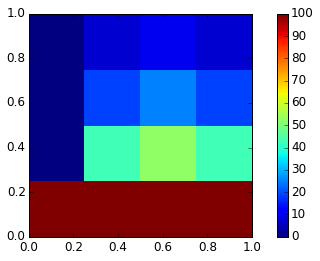

In [10]:
x = y = np.linspace(0, 1, 5)
X, Y = np.meshgrid(x,y)
plt.figure(8)
plt.clf()
plt.pcolor(X, Y, Tfull)
plt.axis('scaled')
plt.colorbar()
plt.savefig('fig05-08.pdf')



<fig05-08.pdf>

# Self study: Solve 2D Laplace equation on an NxN grid

Generalise the above method to solve the Laplace equation and plot the result on an NxN grid. Test it with $N=100$.

## Solution


-   Setup the `A` matrix for the system of linear equations:



In [11]:
N = 5
nblock = N - 2
Bdiag = -4 * np.eye(nblock)
Bupper = np.diag([1] * (nblock - 1), 1)
Blower = np.diag([1] * (nblock - 1), -1)
B = Bdiag + Bupper + Blower
# Creat a list [B,B,B,...,B] with nblock Bs
blst = [B] * nblock
# Unpack the list of diagonal blocks 'blst'
# since block_diag expects each block to be passed as separate
# arguments. This is the same as doing block_diag(B,B,B,...,B)
A = sp.linalg.block_diag(*blst)
# Upper diagonal array offset by nblock: we've got (nblock-1) I blocks
# each containing nblock ones
Dupper = np.diag(np.ones(nblock * (nblock - 1)), nblock)
# Lower diagonal array offset by -nblock
Dlower = np.diag(np.ones(nblock * (nblock - 1)), -nblock)
A += Dupper + Dlower
print A



[[-4.  1.  0.  1.  0.  0.  0.  0.  0.]
 [ 1. -4.  1.  0.  1.  0.  0.  0.  0.]
 [ 0.  1. -4.  0.  0.  1.  0.  0.  0.]
 [ 1.  0.  0. -4.  1.  0.  1.  0.  0.]
 [ 0.  1.  0.  1. -4.  1.  0.  1.  0.]
 [ 0.  0.  1.  0.  1. -4.  0.  0.  1.]
 [ 0.  0.  0.  1.  0.  0. -4.  1.  0.]
 [ 0.  0.  0.  0.  1.  0.  1. -4.  1.]
 [ 0.  0.  0.  0.  0.  1.  0.  1. -4.]]


-   Setup the `b` vector for the system of linear equations:



In [12]:
b = np.zeros(nblock**2)
b[:nblock] = -Te
print "b = \n", b



b = 
[-100. -100. -100.    0.    0.    0.    0.    0.    0.]


-   Solve the equation and embed



In [13]:
u = sp.linalg.solve(A, b)
T = u.reshape((nblock, nblock))
Tfull = embed(T)
print "Tfull = \n", Tfull



Tfull = 
[[ 100.          100.          100.          100.          100.        ]
 [   0.           42.85714286   52.67857143   42.85714286    0.        ]
 [   0.           18.75         25.           18.75          0.        ]
 [   0.            7.14285714    9.82142857    7.14285714    0.        ]
 [   0.            0.            0.            0.            0.        ]]


-   Plot the solution



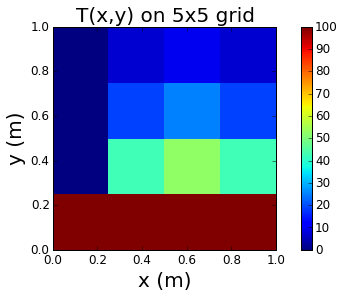

In [14]:
x = y = np.linspace(0, 1, N)
X, Y = np.meshgrid(x,y)
plt.figure(9)
plt.clf()
plt.pcolor(X, Y, Tfull)
plt.axis('scaled')
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('T(x,y) on %dx%d grid' % (N,N))



<fig05-08.pdf>

# References

1.  Jaan Kiusalaas, [Numerical Methods in Engineering with Python](http://www.amazon.com/Numerical-Methods-Engineering-Python-Kiusalaas/dp/0521191327), 2010.
2.  Zwillinger, D. (1998). *Handbook of differential equations (Vol. 1)*. Gulf Professional Publishing.[ {google books} ](https://books.google.co.uk/books?id%3DYD4PL0GZgOcC&printsec%3Dfrontcover&source%3Dgbs_ge_summary_r&cad%3D0#v%3Dsnippet&q%3Dlook%2520up%2520technique&f%3Dfalse)

# Appendix A: pcolor

The function `imshow` follows the layout of the array, with the column index `j` increasing from left to right and the row index `i` from top to bottom. An alterntative is to use the function `pcolor` that uses the usual physical conventions.

When a function of two variables $f(x,y)$ is represented on a structured grid (`X`, `Y`) generated using `meshgrid` (see section "Discretization/2D structured grid"), one can also plot it using the Matplotlib function `pcolor`, which takes three arguments:
-   the `X` grid
-   the `Y` grid
-   the 2D array `F(X,Y)`, having the same dimensions as `X` and `Y`, and representing `f(x,y)`.

In that case, the $x$-axis and $y$-axis follow the usual cartesian representation, with
-   $x$ increasing horizontally from left to right (same as $j$ in `imshow`)
-   $y$ increasing vertically from bottom to top (opposite to $i$ in `imshow`).

For example, using an $11 \times 11$ grid:



In [15]:
x = y = np.linspace(0, 1, 11)
X, Y = np.meshgrid(x, y)



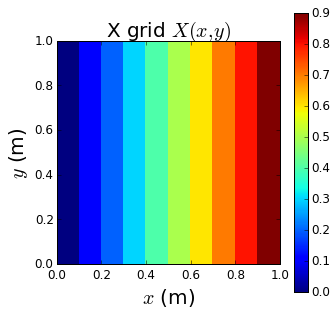

In [16]:
# plot X
fig = plt.figure(9, figsize=(5,5))
plt.clf()
plt.pcolormesh(X, Y, X)
plt.title('X grid $X(x,y)$')
plt.xlabel(r'$x$ (m)')
plt.ylabel(r'$y$ (m)')
plt.colorbar()
h=plt.axis('scaled')
plt.savefig('fig05-09.pdf')



<fig05-09.pdf>



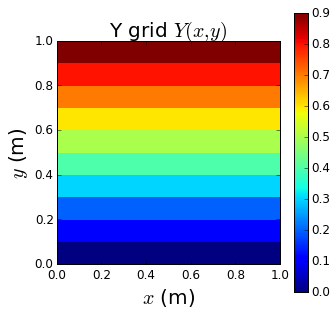

In [17]:
# plot Y
fig = plt.figure(10, figsize=(5,5))
plt.clf()
plt.pcolormesh(X, Y, Y)
plt.title('Y grid $Y(x,y)$')
plt.xlabel(r'$x$ (m)')
plt.ylabel(r'$y$ (m)')
plt.colorbar()
h=plt.axis('scaled')
plt.savefig('fig05-10.pdf')



<fig05-09.pdf>

# Appendix B: Unstructured Mesh

Generate an triangular unstructured mesh using Delauney's algorithm. This algorithm takes a list of points and generates an unstructured triangular mesh. Let's generate a suitable list of points in our 2D square by jiggling the points in a structured grid. The arrays `Xs` and `Ys` are 2D arrays containing the $x$ and $y$ coordinates of the original grid plus a random value of up to $\pm h/2$ in each direction.



In [18]:
# Start from a structured grid
N = 15
x = y = np.linspace(0, 1, N)
X, Y = np.meshgrid(x, y)
# Jiggle the points randomly in the original structured grid
h = x[1] - x[0]
Dx = Dy = np.zeros_like(X)
Dx[1:-1, 1:-1] = h/2 * np.random.rand(N-2, N-2)
Dy[1:-1, 1:-1] = h/2 * np.random.rand(N-2, N-2)
Xs = X + Dx
Ys = Y + Dy



The next step is to generate a list of points by flattening the 2D arrays into 1D arrays, and by zipping them together to get a list of coordinates $(x_i, y_i)$:



In [19]:
# Generate a list points (xi, yi)
xlst = Xs.flatten()
ylst = Ys.flatten()
points = np.array(zip(xlst, ylst))



We can now apply Delauney's algorithm to generate and plot our unstructured mesh:



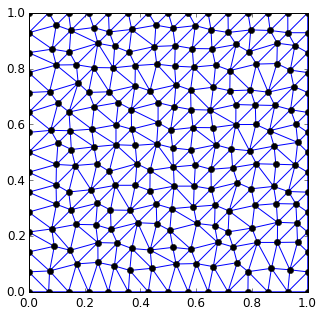

In [20]:
from scipy.spatial import Delaunay

# Generate a triangular mesh
plt.figure(11, figsize=(5,5))
plt.clf()
tri = Delaunay(points)
plt.triplot(points[:,0], points[:,1], tri.simplices.copy())
plt.plot(points[:,0], points[:,1], 'ok')
plt.savefig('fig05-11.pdf')



<fig05-11.pdf>

The triangular mesh stored in the `tri` object is a much more complex structure compared to our original structured mesh. It stores a list of points $(x_i, y_i)$, plus the list of neighbors for each point, plus a list of triangles (the simplices of the mesh), where each triangle is a list containing the integer identifying the nodes the triangle is made of.



In [21]:
# pick a random triangle and plot it in red. The simplices contain the
# connectivity (in this case the list of nodes making up each
# triangle)
nb = tri.neighbors  # list of neighbors
si = tri.simplices  # list of triangles
print 'number of nodes = ', tri.npoints
print 'number of triangles =', len(si)
print 'list of neibours for each node (-1 means boundary): \n', nb



number of nodes =  225
number of triangles = 392
list of neibours for each node (-1 means boundary): 
[[ 46  52  47]
 [ 58  -1   2]
 [ 12 187   1]
 ..., 
 [390 191 388]
 [ 73 389 391]
 [227 390 387]]


Use IPython's interact function to visualise individual triangles in red:



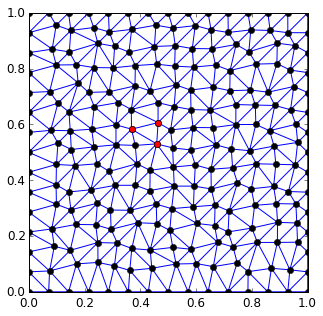

In [24]:
# pick a random triangle and plot it in red
def redtriangle(red_triangle=len(tri.simplices)/2):
    plt.figure(12, figsize=(5,5))
    plt.clf()
    plt.triplot(points[:,0], points[:,1], tri.simplices.copy())
    plt.plot(points[:,0], points[:,1], 'ok')
    rid = red_triangle
    for i in tri.simplices[rid]:
        plt.plot(points[i, 0], points[i, 1], 'or')


if LECTURE:
    i = interact(redtriangle, red_triangle=(0, len(tri.simplices)))
else:
    redtriangle()
print len(tri.simplices)
plt.savefig('fig05-12.pdf')



<fig05-12.pdf>

